In [49]:
# Install a pip package in the current Jupyter kernel
import subprocess
import sys
subprocess.call([sys.executable,"-m","pip","install","numpy","gspread","oauth2client","df2gspread","pandas","matplotlib","seaborn", "pandas-profiling"])


  Using cached argparse-1.4.0-py2.py3-none-any.whl (23 kB)


0

In [50]:
import numpy as np
import pandas as pd
from pandas_profiling import ProfileReport
from pandas.api.types import is_numeric_dtype, is_string_dtype
import gspread
import seaborn
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import textwrap
from itertools import chain
from oauth2client.service_account import ServiceAccountCredentials
import time
from collections import defaultdict
from pathlib import Path

In [51]:
pd.set_option('display.max_rows', 6000)
pd.set_option('display.max_columns', 6000)
pd.set_option('display.width', 6000)
pd.options.display.max_colwidth = 0

In [6]:
data = pd.read_csv("../collected_data/raw_results.csv")
# ProfileReport(data)

def get_column_full_name(keyword_on_column):
    for column in data.columns:
        if keyword_on_column in column:
            return column


In [28]:
def plot_horizontal_distribution(results, category_names, legend_lines, legend_anchor):
    labels = list(results.keys())
    data = np.array(list(results.values()))
    data_cum = data.cumsum(axis=1)
    category_colors = plt.get_cmap('tab20c')(
        np.linspace(0.15, 0.85, data.shape[1]))

    fig, ax = plt.subplots(figsize=(12.2, 1))
    ax.invert_yaxis()
    ax.xaxis.set_visible(False)
    ax.set_xlim(0, np.sum(data, axis=1).max())

    for i, (colname, color) in enumerate(zip(category_names, category_colors)):
        widths = data[:, i]
        starts = data_cum[:, i] - widths
        ax.barh(labels, widths, left=starts, height=0.9,
                label=colname, color=color)
        xcenters = starts + widths / 2

        r, g, b, _ = color
        text_color = 'white' if r * g * b < 0.5 else 'darkgrey'
        for y, (x, c) in enumerate(zip(xcenters, widths)):
            ax.text(x, y, str(int(c)) + '%', ha='center', va='center',
                    color=text_color, fontsize='medium')
    ax.legend(ncol=int(len(category_names) / legend_lines), bbox_to_anchor=legend_anchor,
              loc='lower left', fontsize='medium')

    return fig, ax

In [29]:
# countries
countries = data['Country']
results_size = len(countries)
occurrences = defaultdict(int)

for country in countries:
    if occurrences[country]:
        occurrences[country] = occurrences[country] + 1
    else:
        occurrences[country] = 1

distribution = {key: int(round(value / results_size, 2) * 100) for key, value in occurrences.items()}
sorted_distribution = dict(sorted(distribution.items(), key=lambda item: item[1], reverse=True))

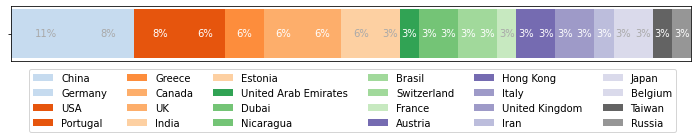

In [36]:
category_names = list(sorted_distribution.keys())
results = {
    '': list(sorted_distribution.values())
}

plot_horizontal_distribution(results, category_names, 4, (0.02, -1.4))

filepath = Path('../figures/dist_country.pdf')
plt.savefig(filepath, format='pdf', bbox_inches='tight')
plt.show()



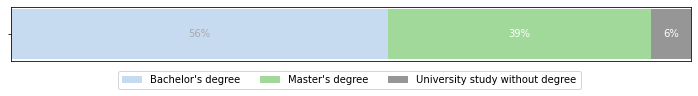

In [45]:
# Education level
def translate_level(level):
    if 'Primary' in level:
        return "Primary school"
    elif 'Secondary' in level:
        return "Secondary school"
    elif 'college' in level:
        return "University study without degree"
    elif 'Bachelor' in level:
        return "Bachelor's degree"
    elif 'Master' in level:
        return "Master's degree"
    elif 'Doctoral' in level:
        return "Doctoral degree"
    else:
        return 'Other'
        


education_levels = data['Educational attainment']
education_answers_size = len(education_levels)
education_occurrences = defaultdict(int)

for edl in education_levels:
    level = translate_level(edl)
    if education_occurrences[level]:
        education_occurrences[level] = education_occurrences[level] + 1
    else:
        education_occurrences[level] = 1

education_distribution = {key: round((value / education_answers_size), 2) * 100 for key, value in education_occurrences.items()}
education_sorted_distribution = dict(sorted(education_distribution.items(), key=lambda item: item[1], reverse=True))

edu_category_names = list(education_sorted_distribution.keys())
edu_results = {
    '': list(education_sorted_distribution.values())
}

plot_horizontal_distribution(edu_results, edu_category_names, 1, (0.15, -0.6))
filepath = Path('../figures/edu_attainment.pdf')
plt.savefig(filepath, format='pdf', bbox_inches='tight')
plt.show()

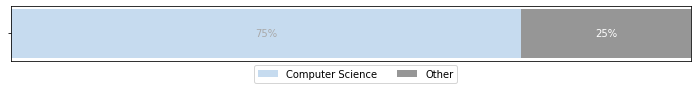

In [46]:
# Area of study

def translate_to_computer_science(area):
    similar_areas = ['Computer', 'computer', 'Computation', 'computation', 'Informatics', 'informatics',
                     'Software', 'software', 'IT', 'informatic', 'Information', 'information']
    
    if any(x in area for x in similar_areas):
        return 'Computer Science'
    else:
        return 'Other'


study_area_column_name = get_column_full_name('study')
study_areas = data[study_area_column_name]
study_areas_answers = len(study_areas)
areas_occurrences = defaultdict(int)

for area in study_areas:
    translated_area = translate_to_computer_science(area)
    if areas_occurrences[translated_area]:
        areas_occurrences[translated_area] = areas_occurrences[translated_area] + 1
    else:
        areas_occurrences[translated_area] = 1

area_distribution = {key: (value / study_areas_answers) * 100 for key, value in areas_occurrences.items()}
area_distribution_sorted = dict(sorted(area_distribution.items(), key=lambda item: item[1], reverse=True))

areas_names = list(area_distribution_sorted.keys())
area_results = {
    '': list(area_distribution_sorted.values())
}

plot_horizontal_distribution(area_results, areas_names, 1, (0.35, -0.5))
filepath = Path('../figures/area_study.pdf')
plt.savefig(filepath, format='pdf', bbox_inches='tight')
plt.show()


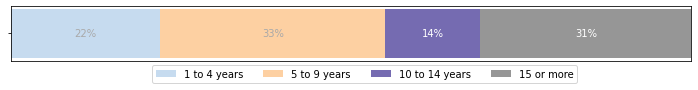

In [48]:
profexp_column_name = get_column_full_name('Professional')
prof_exp_options = data[profexp_column_name]
prof_exp_answers = len(prof_exp_options)
prof_exp_occ = defaultdict(int)

def get_prof_item_order(item):
    if '1 to 4' in item:
        return 1
    elif '5 to 9' in item:
        return 2
    elif '10 to 14' in item:
        return 3
    elif '15' in item:
        return 4
    else:
        return 0

for prof_exp in prof_exp_options:
    if prof_exp_occ[prof_exp]:
        prof_exp_occ[prof_exp] = prof_exp_occ[prof_exp] + 1
    else:
        prof_exp_occ[prof_exp] = 1

prof_exp_dist = {key: round((value / prof_exp_answers), 2) * 100 for key, value in prof_exp_occ.items()}
prof_exp_dist_sorted = dict(sorted(prof_exp_dist.items(), key=lambda item: get_prof_item_order(item[0])))
#prof_exp_dist_sorted = prof_exp_dist

prof_exp_names = list(prof_exp_dist_sorted.keys())
prof_exp_values = {
    '': list(prof_exp_dist_sorted.values())
}

plot_horizontal_distribution(prof_exp_values, prof_exp_names, 1, (0.20, -0.5))
filepath = Path('../figures/professional_experience.pdf')
plt.savefig(filepath, format='pdf', bbox_inches='tight')
plt.show()